In [1]:
import pandas as pd
import os
import sklearn
import numpy as np
from scipy.interpolate import *
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as k
import seaborn as sns
#pd.set_option('display.max_rows', None)


In [2]:
os.getcwd()

'C:\\Users\\User\\Documents\\GitHub\\Hypertension_prediction\\Hypertension(regularly sampled data)\\Codebase(previous paper codes)\\Hypertension_code_amy'

In [3]:
#df = pd.read_excel (r'Mappings.xlsx')
p9690 =pd.read_csv (r'./Output/missing_value_imputed/p9690_missing.csv')#,parse_dates=['Timestamp'], index_col=['Timestamp'])
p9630 =pd.read_csv (r'./Output/missing_value_imputed/p9630_missing.csv')#, parse_dates=['Timestamp'], index_col=['Timestamp'])
p9888 =pd.read_csv (r'./Output/missing_value_imputed/p9888_missing.csv')#, parse_dates=['Timestamp'], index_col=['Timestamp'])
p10049=pd.read_csv (r'./Output/missing_value_imputed/p10049_missing.csv')#, parse_dates=['Timestamp'], index_col=['Timestamp'])
p10412=pd.read_csv (r'./Output/missing_value_imputed/p10412_missing.csv')#, parse_dates=['Timestamp'], index_col=['Timestamp'])

In [4]:
#!git clone https://github.com/caow13/BRITS.git

In [5]:
#from sklearn.impute import KNNImputer
#p10049_knn_imputed = p10049.copy(deep=True)
#knn_imp = KNNImputer(n_neighbors=3)
#p10049_knn_imputed.loc[:, :] = knn_imp.fit_transform(p10049_knn_imputed)


In [6]:
#from sklearn.datasets import make_friedman2
#from sklearn.gaussian_process import GaussianProcessRegressor
#from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
#X, y = make_friedman2(n_samples=500, noise=0, random_state=0)
#kernel = DotProduct() + WhiteKernel()
#gpr = GaussianProcessRegressor(kernel=kernel,
#        random_state=0).fit(X, y)
#gpr.score(X, y)

#gpr.predict(X[:2,:], return_std=True)


first create patient train test set

In [7]:
p10049['Timestamp'] = pd.to_datetime(p10049['Timestamp'])
p10049['DOB'] = pd.to_datetime(p10049['DOB'])
p10049.set_index('Timestamp', inplace=True)

In [8]:
p10049.dtypes

UserID               float64
Systolic             float64
Diastolic            float64
Heart Rate           float64
DOB           datetime64[ns]
Weight               float64
Height               float64
Gender                object
dtype: object

In [9]:
p10049_s= p10049['Systolic']
p10049_d= p10049['Diastolic']
p10049_hr= p10049['Heart Rate']
p10049_all= p10049[['Systolic','Diastolic','Heart Rate']]
p10049_s_train,p10049_s_test= np.split(p10049_s, [int(.7 *len(p9690))])
p10049_d_train,p10049_d_test= np.split(p10049_d, [int(.7 *len(p9690))])
p10049_hr_train,p10049_hr_test= np.split(p10049_hr, [int(.7 *len(p9690))])
p10049_all_train,p10049_all_test= np.split(p10049_all, [int(.7 *len(p9690))])



interpolation

In [10]:
df_poly_imputed = p10049_all.interpolate(method='polynomial', order=2)
df_time_imputed = p10049_all.interpolate(method='time')
df_spline_imputed = p10049_all.interpolate(method='spline', order=2)
df_barycentric_imputed = p10049_all.interpolate(method='barycentric', order=2)


C:\Users\User\anaconda3\envs\Hypertension_env\lib\site-packages\scipy\interpolate\polyint.py:539: RuntimeWarning: overflow encountered in multiply
  self.wi[:j] *= (self.xi[j]-self.xi[:j])
C:\Users\User\anaconda3\envs\Hypertension_env\lib\site-packages\scipy\interpolate\polyint.py:540: RuntimeWarning: overflow encountered in reduce
  self.wi[j] = np.multiply.reduce(self.xi[:j]-self.xi[j])
C:\Users\User\anaconda3\envs\Hypertension_env\lib\site-packages\scipy\interpolate\polyint.py:637: RuntimeWarning: invalid value encountered in true_divide
  p = np.dot(c,self.yi)/np.sum(c,axis=-1)[...,np.newaxis]


KNN Inputation

In [11]:
# Imputing with KNNImputer

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

#Define a subset of the dataset
df_knn = p10049_all.copy()
#p9690.filter(['Systolic','Diastolic','Heart Rate'], axis=1).copy()


# Define scaler to set values between 0 and 1

scaler = MinMaxScaler(feature_range=(0, 1))
df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns = df_knn.columns)

# Define KNN imputer and fill missing values
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)


Multivariate Imputation by Chained Equations (MICE)

In [12]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

df_mice = p10049_all.copy()

# Define MICE Imputer and fill missing values
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)

In [18]:
#!pip install adtk


RangeIndex(start=0, stop=7322, step=1)

In [14]:
from adtk.data import validate_series
#df_poly_imputed.index
df_poly_imputed= validate_series(df_poly_imputed)
print(df_poly_imputed)

                     Systolic  Diastolic  Heart Rate
Timestamp                                           
2018-05-17 10:00:00     108.5       72.0        24.5
2018-05-17 11:00:00     119.0       76.0        53.0
2018-05-17 12:00:00     123.0       81.0        82.0
2018-05-17 13:00:00     126.0       87.0        96.0
2018-05-17 14:00:00     121.5       80.0        40.0
...                       ...        ...         ...
2019-03-18 07:00:00     120.0       83.0        88.0
2019-03-18 08:00:00     123.0       81.0        80.0
2019-03-18 09:00:00     121.0       83.0        88.0
2019-03-18 10:00:00     122.0       84.0        88.0
2019-03-18 11:00:00     123.0       80.0        79.0

[7322 rows x 3 columns]


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

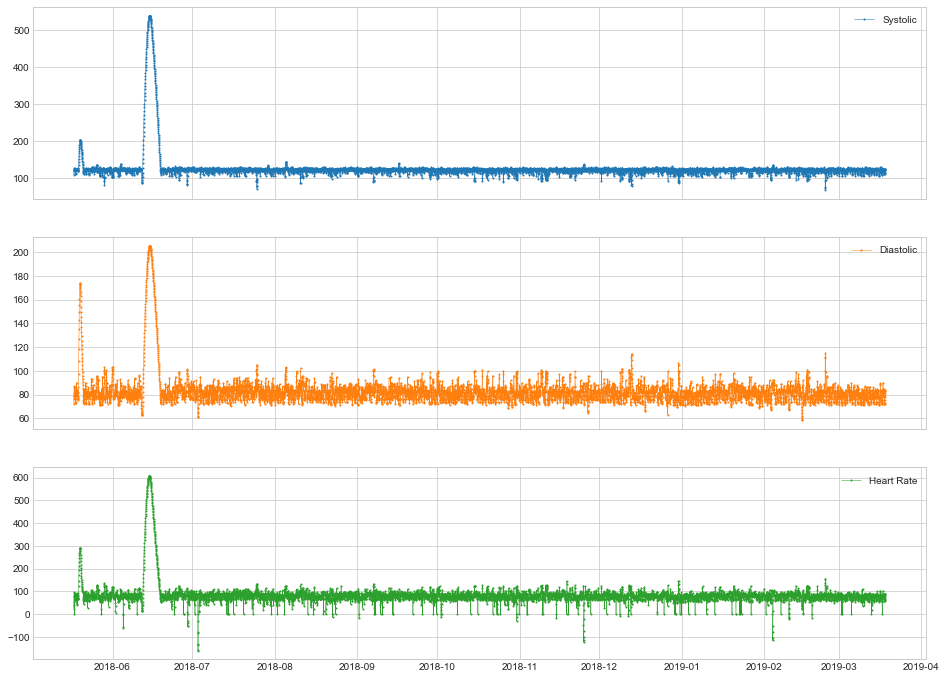

In [15]:
from adtk.visualization import plot
plot(df_poly_imputed)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

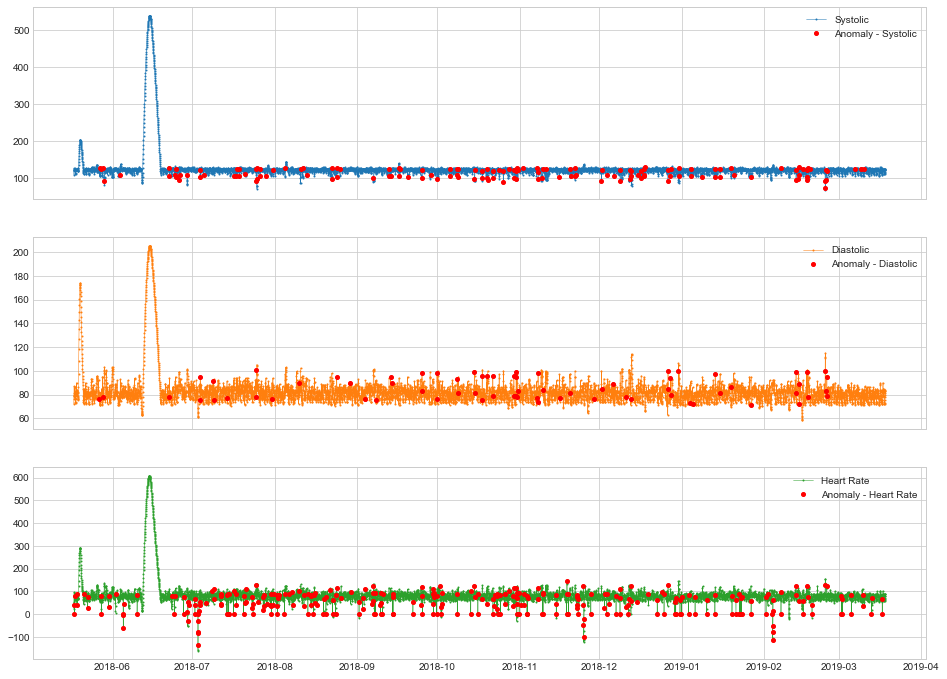

In [22]:
from adtk.detector import *
autoregression_ad = AutoregressionAD()
anomalies = autoregression_ad.fit_detect(df_poly_imputed)
parameter = autoregression_ad.get_params()

plot(df_poly_imputed, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")

In [23]:
parameter

{'n_steps': 1,
 'step_size': 1,
 'regressor': LinearRegression(),
 'c': 3.0,
 'side': 'both'}

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

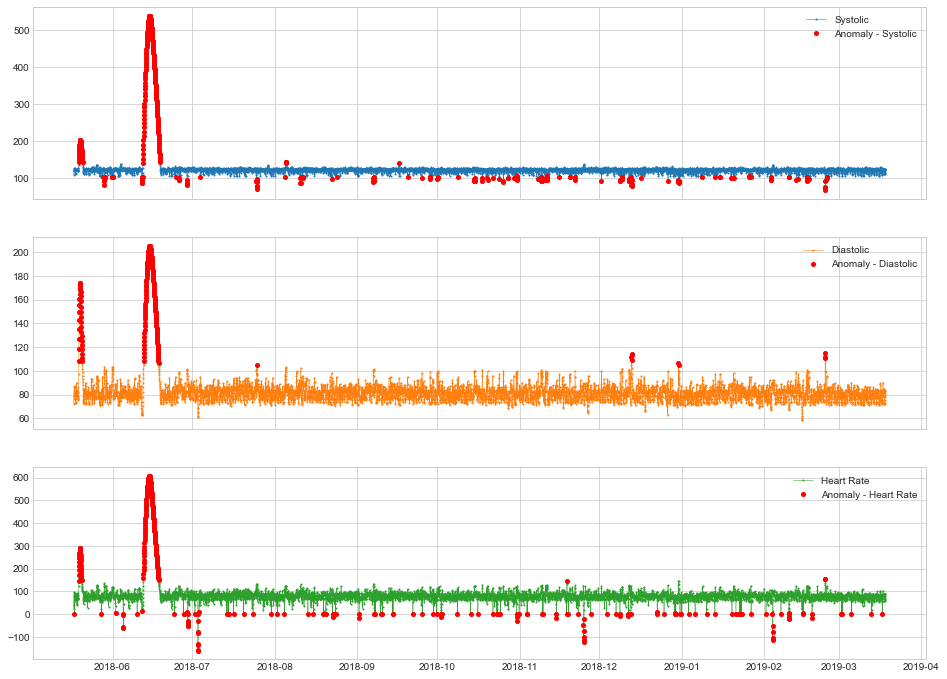

In [24]:

IQR_AD = InterQuartileRangeAD()
anomalies = IQR_AD.fit_detect(df_poly_imputed)
#parameter = IQR_AD.get_params()
plot(df_poly_imputed, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

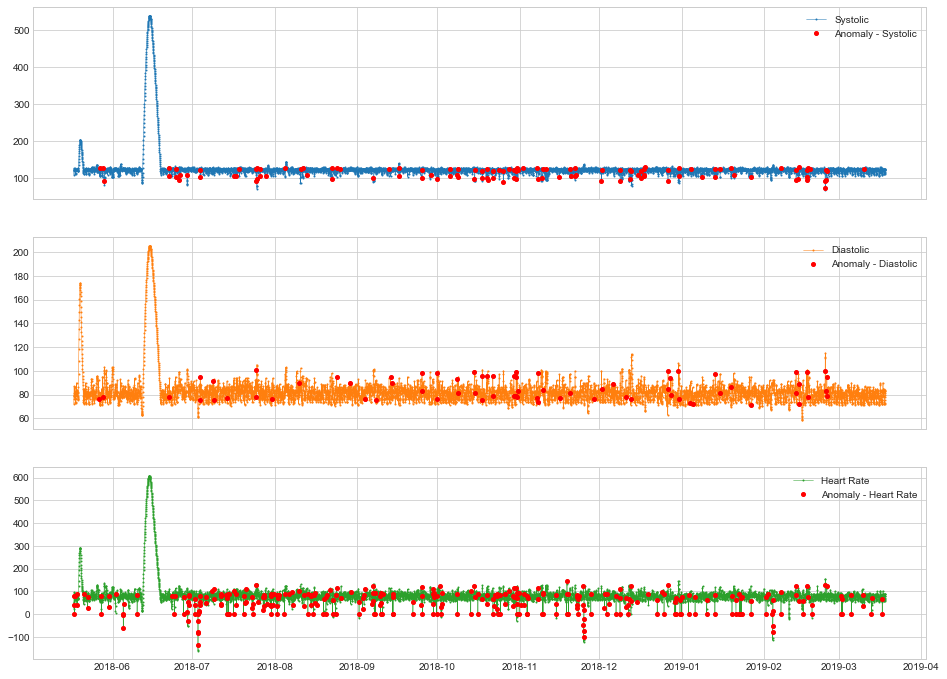

In [25]:
#compares time series values with the values of their preceding time windows, and identifies a time point as anomalous if the change of value from its preceding average or median is anomalously large
Persist_AD = PersistAD()
anomalies = Persist_AD.fit_detect(df_poly_imputed)
#parameter = IQR_AD.get_params()
plot(df_poly_imputed, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")

#must seperate since cannot set threshold manually

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

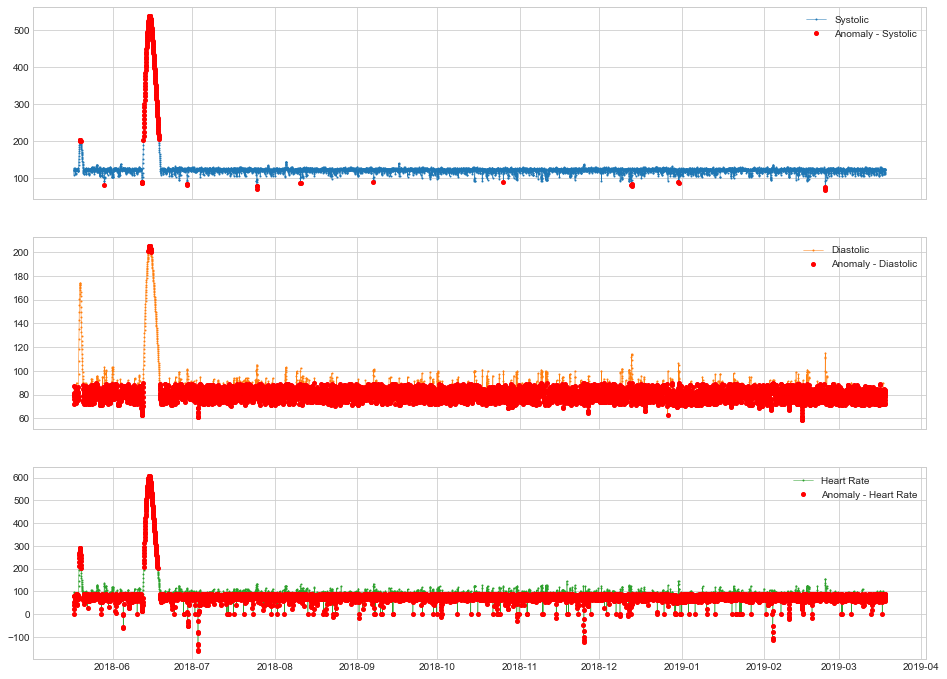

In [28]:
Threshold_AD = ThresholdAD(low=90, high=200)
anomalies = Threshold_AD.detect(df_poly_imputed)
plot(df_poly_imputed, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")

In [31]:
OutlierDetector = OutlierDetector(IsolationForest)
anomalies = OutlierDetector.fit_detect(df_poly_imputed)
plot(df_poly_imputed, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")

NameError: name 'IsolationForest' is not defined

In [32]:
#print_all_models()

--------------------------------------------------------------------------------
ThresholdAD
Detector that detects anomaly based on user-given threshold.

    This detector compares time series values with user-given thresholds, and
    identifies time points as anomalous when values are beyond the thresholds.

    Parameters
    ----------
    low: float, optional
        Threshold below which a value is regarded anomaly. Default: None, i.e.
        no threshold on lower side.

    high: float, optional
        Threshold above which a value is regarded anomaly. Default: None, i.e.
        no threshold on upper side.

    
--------------------------------------------------------------------------------
CustomizedDetector1D
Univariate detector derived from a user-given function and parameters.

    Parameters
    ----------
    detect_func: function
        A function detecting anomalies from univariate time series.

        The first input argument must be a pandas Series, optional inp